# Set up

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [ ]:
parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
data_dir = os.path.join(parent_dir, 'data')
models_dir = os.path.join(parent_dir, 'models')
for dir in [parent_dir, data_dir, models_dir]:
    os.makedirs(dir, exist_ok=True)
print('working directory: ', os.getcwd())
print('data directory:    ', data_dir, )
print('models directory:  ', models_dir)

In [ ]:
# change pandas column width so we can see the posts
pd.get_option('max_colwidth')
pd.set_option('max_colwidth', 1000)

# Data preparation

In [ ]:
data_candidates = pd.read_csv(os.path.join(data_dir, 'fb_election_data_28112017.csv'))
data_candidates = data_candidates[['from_name', 'message', 'type', 'Partei_ABK']] # drop other columns
data_candidates = data_candidates[data_candidates['message'].notnull()] # filter out empty posts
data_candidates['word_count'] = data_candidates['message'].str.count(' ') + 1
#data_party['message'] = data_party['message'].astype(str)

In [ ]:
party_names = {'AfD': 'AfD',
               'DIE LINKE': 'DIE LINKE',
               'BÜNDNIS 90/DIE GRÜNEN': 'GRÜNE',
               'CSU (Christlich-Soziale Union)': 'CSU',
               'CDU': 'CDU',
               'FDP': 'FDP',
               'SPD': 'SPD'}
data_parties =  pd.read_csv((os.path.join(data_dir, 'party_data.csv')))
data_parties['Partei_ABK'] = data_parties['from_name'].map(party_names)
data_parties['from_name'] = data_parties['Partei_ABK'] + ' Party'
data_parties = data_parties[['from_name', 'message', 'type', 'Partei_ABK']] # drop other columns

In [ ]:
data = data_candidates.append(data_parties)
data = data[data['message'].notnull()] # filter out empty posts
data.index = pd.Index(range(len(data)))  # make sure the index are unique increasing numbers
data.to_pickle(os.path.join(data_dir, 'data_clean_4cols_2.pickle'))  # save the data as pickle for faster loading
#data = pd.read_pickle(os.path.join(data_dir, 'data_clean_4cols_2.pickle'))  # data can be read  like this

# Inspect the data

In [ ]:
# take a peek a the data
data_candidates[data_candidates['from_name'] == 'Angela Merkel'].head()

# Descriptive statistics

## Summary by candidate

In [ ]:
# filter out party leaders 
leaders = ['Sahra Wagenknecht',
'Dietmar Bartsch',
'Katrin Göring-Eckardt',
'Cem Özdemir',
'Martin Schulz',
'Angela Merkel',
'Joachim Herrmann',
'Alexander Gauland',
'Alice Weidel']

In [ ]:
data_candidates['word_count'] = data_candidates['message'].str.count(' ') + 1
candidate_summary = pd.DataFrame()
candidate_summary = (data_candidates
                  .drop(['message', 'word_count', 'type'], axis=1)
                  .drop_duplicates('from_name')
                  .set_index('from_name'))
candidate_summary['leader'] = candidate_summary.index.isin(leaders)
candidate_summary['mean_word_count'] = data_candidates.groupby('from_name')['word_count'].mean().round(2)
candidate_summary['median_word_count'] = data_candidates.groupby('from_name')['word_count'].median()
candidate_summary['post_count'] = data_candidates['from_name'].value_counts()
candidate_summary['total_words'] =  data_candidates.groupby('from_name')['word_count'].sum()

In [19]:
candidate_summary[candidate_summary['leader']].sort_values('Partei_ABK')
#candidate_summary[candidate_summary['Partei_ABK'] == 'GRÜNE'].sort_values('post_count', ascending=False).head()
#candidate_summary.sort_values('post_count', ascending=False)

,Partei_ABK,leader,mean_word_count,median_word_count,post_count,total_words
from_name,,,,,,
Alice Weidel,AfD,True,72.13,40.0,407,29357
Angela Merkel,CDU,True,49.91,43.0,235,11729
Joachim Herrmann,CSU,True,36.07,20.0,431,15546
Dietmar Bartsch,DIE LINKE,True,75.69,64.0,347,26264
Sahra Wagenknecht,DIE LINKE,True,99.63,88.0,335,33377
Katrin Göring-Eckardt,GRÜNE,True,42.66,38.0,293,12500
Cem Özdemir,GRÜNE,True,37.79,25.0,347,13113
Martin Schulz,SPD,True,64.51,50.0,386,24899


## Summary by party

In [ ]:
party_colors = {'AfD': 'xkcd:blue',
                'DIE LINKE': 'xkcd:magenta',
                'GRÜNE': 'xkcd:grass green',
                'CSU': 'xkcd:sky blue',
                'CDU': 'xkcd:black',
                'FDP': 'xkcd:goldenrod',
                'SPD': 'xkcd:red'}

In [ ]:
party_summary = pd.DataFrame()
party_summary['words_per_post'] = data_candidates.groupby('Partei_ABK')['word_count'].mean()
party_summary['word_count'] = data_candidates.groupby('Partei_ABK')['word_count'].sum()
party_summary['post_count'] = data_candidates['Partei_ABK'].value_counts()
party_summary['candidate_count'] = candidate_summary['Partei_ABK'].value_counts()
party_summary['posts_per_candidate'] = party_summary['post_count'] / party_summary['candidate_count']
party_summary['words_per_candidate'] = party_summary['word_count'] / party_summary['candidate_count']
party_summary.reset_index(inplace=True)
cm = sns.light_palette("blue", as_cmap=True)
#party_summary.style.background_gradient(cmap=cm, axis=0, high=0.8)

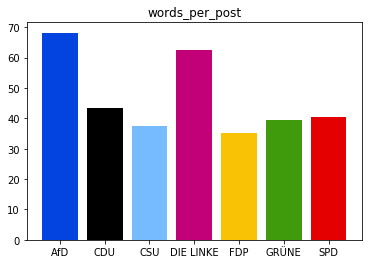

In [21]:
show = 'words_per_post' # words_per_post, words_per_candidate
fig, ax = plt.subplots()
ax.bar(party_summary['Partei_ABK'],
        party_summary[show],
        color=party_summary['Partei_ABK'].map(party_colors))
ax.set_title(show)
plt.show()

###### More plots

In [ ]:
f, axes = plt.subplots(2, 3, sharex=True, figsize=(15,10))
#for x, y in product([0, 1], [0, 1, 2]))
axes[0, 0].bar(party_summary['Partei_ABK'],
        party_summary['candidate_count'],
        color=party_summary['Partei_ABK'].map(party_colors))
axes[0, 0].set_title('candidate_count')

axes[0, 1].bar(party_summary['Partei_ABK'],
        party_summary['post_count'],
        color=party_summary['Partei_ABK'].map(party_colors))
axes[0, 1].set_title('post_count')

axes[0, 2].bar(party_summary['Partei_ABK'],
        party_summary['word_count'],
        color=party_summary['Partei_ABK'].map(party_colors))
axes[0, 2].set_title('word_count')

axes[1, 0].bar(party_summary['Partei_ABK'],
        party_summary['words_per_candidate'],
        color=party_summary['Partei_ABK'].map(party_colors))
axes[1, 0].set_title('words_per_candidate')

axes[1, 1].bar(party_summary['Partei_ABK'],
        party_summary['posts_per_candidate'],
        color=party_summary['Partei_ABK'].map(party_colors))
axes[1, 1].set_title('posts_per_candidate')

axes[1, 2].bar(party_summary['Partei_ABK'],
        party_summary['words_per_post'],
        color=party_summary['Partei_ABK'].map(party_colors))
axes[1, 2].set_title('words_per_post')

plt.show()

###### Post types

In [ ]:
post_summary = pd.DataFrame()
post_summary['mean_word_count'] = data_candidates.groupby('type')['word_count'].mean()
post_summary['post_count'] = data_candidates['type'].value_counts()
post_summary

In [ ]:
parties_posttypes = pd.crosstab(data_candidates['type'], data_candidates['Partei_ABK'])
import seaborn as sns
cm = sns.light_palette("blue", as_cmap=True)
parties_posttypes = parties_posttypes.style.background_gradient(cmap=cm, axis=0, high=0.8)
#parties_posttypes

###### Distribution of post lengths

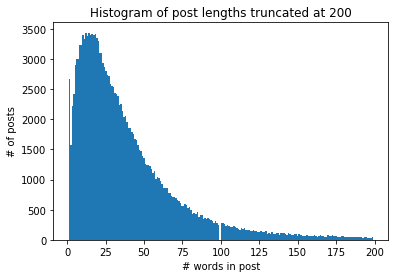

In [22]:
plt.figure()
n, bins, patches = plt.hist(x=data_candidates['word_count'][data_candidates['word_count']<200], bins=200)
plt.xlabel('# words in post')
plt.ylabel('# of posts')
plt.title('Histogram of post lengths truncated at 200')
plt.show()

# Prepare data

In [ ]:
from nltk.tokenize.casual import TweetTokenizer
from nltk.corpus import stopwords
import string

#tokenizer = RegexpTokenizer(r'\w+')
tokenizer = TweetTokenizer
stopword_set = set(stopwords.words('german'))
#This function does all cleaning of data using two objects above
def nlp_clean(messages):
    new_data = []
    for message in messages:
        message = message.lower()
        message = tokenizer().tokenize(message)
        words = [word for word in message if (word not in stopword_set
                                              and word not in string.punctuation
                                              and not word.startswith('http'))]
        #word_list = tokenizer.tokenize(message)
        #word_list = list(set(dlist).difference(stopword_set))
        new_data.append(words)
    return new_data

In [ ]:
example_post = data_candidates[data_candidates['from_name'] == 'Angela Merkel'].loc[108901,'message']
example_post

In [ ]:
nlp_clean([example_post])